In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from gwtransport import advection, diffusion2
from gwtransport import gamma as gamma_utils
from gwtransport.examples import generate_example_data

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

print("Libraries imported successfully")

Libraries imported successfully


## 1. Generate Test Data


# Testing Model Assumptions: When Can Diffusion Be Neglected?

The transport models in Examples 1-4 assume **advection-dominated transport**, neglecting diffusion and mechanical dispersion. This notebook helps you determine whether this assumption is valid for your case.


## Variance Addition Rule

Transport in aquifers involves two processes:

- **Advection**: Transport by water flow (heterogeneity creates spreading)
- **Diffusion/Dispersion**: Molecular diffusion and mechanical dispersion

When independent, their variances add:

$$\sigma^2_{total} = \sigma^2_{advection} + \sigma^2_{diffusion}$$

Diffusion can be neglected when the variance ratio is small:

$$\frac{\sigma^2_{diffusion}}{\sigma^2_{advection}} \ll 0.1$$

Three methods of modeling diffusion / dispersion are implemented:

- **gwtransport.advection.gamma_infiltration_to_extraction** Fastest. Increase the spread of the aquifer pore volume distribution by raising the `std` argument (see note below)
- **gwtransport.diffusion.infiltration_to_extraction** Fast. Mathematically only correct for constant `tedges`, constant `cout_tedges`, and constant `flow`. Incorrect where transitions occur.
- **gwtransport.diffusion2.infiltration_to_extraction** Slow. Correct, also for fluctuating `flow` and varying `tedges` and `cout_tedges`.

**Note**

The diffusion/dispersion can also be modeled as additional spreading of the aquifer pore volume distribution by increasing the `std` argument in the `gwtransport.advection.gamma_infiltration_to_extraction` method. Increase the `std` with:

- $\Delta \sigma_{apv}$ = aquifer_pore_volume_gamma_mean * np.sqrt(2 * diffusion_coefficient * rt_mean) / (aquifer_length * df.attrs["retardation_factor"])

In [2]:
# Generate 6 years of daily data with seasonal patterns, the same as plotted in Example 1
df, tedges = generate_example_data(
    date_start="2020-01-01",
    date_end="2025-05-31",
    flow_mean=120.0,  # Base flow rate [m³/day]
    flow_amplitude=40.0,  # Seasonal flow variation [m³/day]
    flow_noise=5.0,  # Random daily fluctuations [m³/day]
    temp_infiltration_method="soil_temperature",  # Use real soil temperature data
    aquifer_pore_volume_gamma_mean=8000.0,  # True mean pore volume [m³]
    aquifer_pore_volume_gamma_std=400.0,  # True standard deviation [m³]
    retardation_factor=2.0,  # Thermal retardation factor [-]
    temp_measurement_noise=0.1,  # Measurement noise for temperatures. Set to zero for perfect fit.[°C]
)
nbins = 5

In [3]:
# The gamma requires two parameters for configuration, either the mean and standard deviation or alpha and beta.
# Define gamma distribution bins for aquifer pore volume with alpha and beta (scale) parameters, instead of mean and std.
gbins_apv = gamma_utils.bins(
    alpha=df.attrs["aquifer_pore_volume_gamma_alpha"], beta=df.attrs["aquifer_pore_volume_gamma_beta"], n_bins=nbins
)
print(
    f"Aquifer pore volume distribution mean: {df.attrs['aquifer_pore_volume_gamma_mean']:.1f} m³, "
    f"std: {df.attrs['aquifer_pore_volume_gamma_std']:.1f} m³"
)
# The apv distribution is scaled by the mean flow to get the residence time distribution.
# Define gamma distribution bins for residence time with alpha and beta (scale) parameters, instead of mean and std.
gbins_rt = gamma_utils.bins(
    alpha=df.attrs["aquifer_pore_volume_gamma_alpha"],
    beta=df.attrs["aquifer_pore_volume_gamma_beta"] / df.attrs["flow_mean"],
    n_bins=nbins,
)
# The mean and std of the residence time distribution can be calculated from the apv distribution and mean flow.
rt_mean, rt_std = gamma_utils.alpha_beta_to_mean_std(
    alpha=df.attrs["aquifer_pore_volume_gamma_alpha"],
    beta=df.attrs["aquifer_pore_volume_gamma_beta"] / df.attrs["flow_mean"],
)
print(f"With a mean flow of {df.attrs['flow_mean']:.1f} m³/day:")
print(f"Results in a residence time distribution mean: {rt_mean:.1f} days, std: {rt_std:.1f} days")

Aquifer pore volume distribution mean: 8000.0 m³, std: 400.0 m³
With a mean flow of 120.0 m³/day:
Results in a residence time distribution mean: 66.7 days, std: 3.3 days


## 2. Analytical Variance Check

We first perform an analytical check by comparing the variance contributions from advection (due to aquifer heterogeneity) and diffusion.


In [4]:
diffusion_coefficient = 0.1  # [m²/day] Diffusion coefficient, upper end for saturated sand.
aquifer_length = 100.0  # [m] Length of the aquifer

pore_flow_velocity = aquifer_length * df.attrs["retardation_factor"] / rt_mean  # [m/day] Pore flow velocity
diffusion_std = (
    np.sqrt(2 * diffusion_coefficient * rt_mean) / pore_flow_velocity
)  # Convert spatial to temporal spreading
print(f"The resulting standard deviation of the temporal spreading due to diffusion is {diffusion_std:.2f} days.")

The resulting standard deviation of the temporal spreading due to diffusion is 1.22 days.


In [5]:
print("Variance Comparison:")
print("=" * 80)
print(f"Advection variance (from aquifer heterogeneity): {rt_std**2:.2f} days²")
print(f"Diffusion variance (from dispersive spreading):  {diffusion_std**2:.2f} days²")
print(f"Variance ratio (diffusion/advection):            {diffusion_std**2 / rt_std**2:.3f}")
print("=" * 80)

if diffusion_std**2 / rt_std**2 < 0.1:
    print("\n✓ CONCLUSION: Diffusion can be NEGLECTED")
    print(f"  Diffusion contributes only {diffusion_std**2 / rt_std**2 * 100:.1f}% of total variance")
    print(f"  Advection dominates by a factor of {rt_std**2 / diffusion_std**2:.1f}")
elif diffusion_std**2 / rt_std**2 < 0.5:
    print("\n⚠ CONCLUSION: Diffusion is MINOR but may affect results")
    print(f"  Diffusion contributes {diffusion_std**2 / rt_std**2 * 100:.1f}% of total variance")
    print("  Consider including diffusion for high-precision work")
else:
    print("\n✗ CONCLUSION: Diffusion MUST be included")
    print(f"  Diffusion contributes {diffusion_std**2 / rt_std**2 * 100:.1f}% of total variance")
    print("  Neglecting diffusion will introduce significant error")

Variance Comparison:
Advection variance (from aquifer heterogeneity): 11.11 days²
Diffusion variance (from dispersive spreading):  1.48 days²
Variance ratio (diffusion/advection):            0.133

⚠ CONCLUSION: Diffusion is MINOR but may affect results
  Diffusion contributes 13.3% of total variance
  Consider including diffusion for high-precision work


## 3. Visual Demonstration

Compare transport models with and without diffusion to see the actual effect.


### Sharp Pulse Test


In [6]:
# Create a sharp pulse in the middle of the time series
pulse_signal = np.zeros(len(df))
pulse_center = len(df) // 2
pulse_width = 5  # days
pulse_signal[pulse_center : pulse_center + pulse_width] = 100.0  # mg/L

# Apply advection only (heterogeneous flow paths, no diffusion)
pulse_advection_only = advection.gamma_infiltration_to_extraction(
    cin=pulse_signal,
    flow=df.flow,
    tedges=tedges,
    cout_tedges=tedges,
    mean=df.attrs["aquifer_pore_volume_gamma_mean"],
    std=df.attrs["aquifer_pore_volume_gamma_std"],
    n_bins=nbins,
    retardation_factor=1.0,  # Conservative solute
)

# Apply advection with diffusion directly from infiltration using diffusion2 module
# This uses a single pore volume (mean) with diffusion, rather than the heterogeneous gamma distribution
# This allows us to see the effect of diffusion alone
streamline_lengths = np.full_like(gbins_apv["expected_values"], fill_value=aquifer_length)
pulse_advection_diffusion = diffusion2.infiltration_to_extraction(
    cin=pulse_signal,
    flow=df.flow.values,
    tedges=tedges,
    cout_tedges=tedges,
    aquifer_pore_volumes=gbins_apv["expected_values"],
    streamline_length=streamline_lengths,
    diffusivity=diffusion_coefficient,
    retardation_factor=1.0,  # Conservative solute
)

print("Pulse transport calculated with two scenarios:")
print("1. Advection with heterogeneity (gamma-distributed pore volumes, no diffusion)")
print("2. Advection with diffusion (single mean pore volume, with diffusion)")

Pulse transport calculated with two scenarios:
1. Advection with heterogeneity (gamma-distributed pore volumes, no diffusion)
2. Advection with diffusion (single mean pore volume, with diffusion)


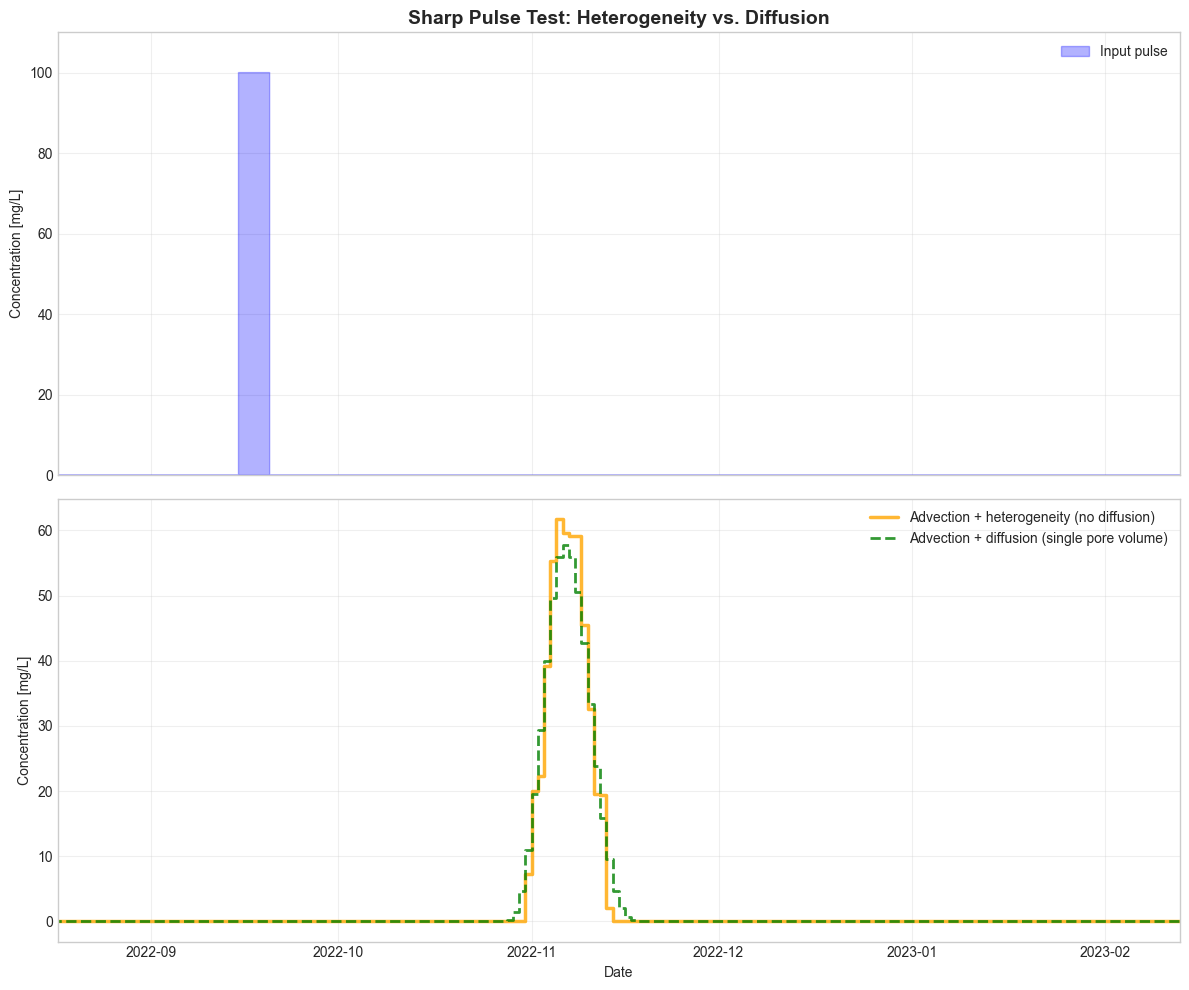


Pulse breakthrough plot saved to: 05_Pulse_breakthrough_comparison.png


In [7]:
# Plot the pulse breakthrough curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top panel: Input pulse - convert to step format
xstep_pulse, ystep_pulse = np.repeat(tedges, 2)[1:-1], np.repeat(pulse_signal, 2)
ax1.fill_between(xstep_pulse, 0, ystep_pulse, alpha=0.3, color="blue", label="Input pulse")
ax1.set_ylabel("Concentration [mg/L]")
ax1.set_title("Sharp Pulse Test: Heterogeneity vs. Diffusion", fontsize=14, fontweight="bold")
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 110])
ax1.set_xlim([df.index[pulse_center - 30], df.index[pulse_center + 150]])

# Bottom panel: Output breakthrough curves - convert to step format
xstep_adv, ystep_adv = np.repeat(tedges, 2)[1:-1], np.repeat(pulse_advection_only, 2)
xstep_diff, ystep_diff = np.repeat(tedges, 2)[1:-1], np.repeat(pulse_advection_diffusion, 2)
ax2.plot(
    xstep_adv,
    ystep_adv,
    label="Advection + heterogeneity (no diffusion)",
    color="orange",
    linewidth=2.5,
    alpha=0.8,
)
ax2.plot(
    xstep_diff,
    ystep_diff,
    label="Advection + diffusion (single pore volume)",
    color="green",
    linewidth=2,
    linestyle="--",
    alpha=0.8,
)
ax2.set_ylabel("Concentration [mg/L]")
ax2.set_xlabel("Date")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save plot
out_path = Path("05_Pulse_breakthrough_comparison.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"\nPulse breakthrough plot saved to: {out_path}")

### Temperature Test


In [8]:
# Apply temperature transport with advection only (current model in Examples 1-4)
# Uses gamma-distributed pore volumes for heterogeneity
temp_advection_only = advection.gamma_infiltration_to_extraction(
    cin=df.temp_infiltration,
    flow=df.flow,
    tedges=tedges,
    cout_tedges=tedges,
    mean=df.attrs["aquifer_pore_volume_gamma_mean"],
    std=df.attrs["aquifer_pore_volume_gamma_std"],
    n_bins=nbins,
    retardation_factor=2.0,  # Thermal retardation
)

# Apply temperature transport with advection + diffusion directly from infiltration
# Uses a single pore volume (mean) with diffusion
temp_advection_diffusion = diffusion2.infiltration_to_extraction(
    cin=df.temp_infiltration.values,
    flow=df.flow.values,
    tedges=tedges,
    cout_tedges=tedges,
    aquifer_pore_volumes=gbins_apv["expected_values"],
    streamline_length=streamline_lengths,
    diffusivity=diffusion_coefficient,
    retardation_factor=2.0,  # Thermal retardation
)

print("Temperature transport calculated with:")
print("1. Advection only (gamma-distributed pore volumes, no diffusion)")
print("2. Advection with diffusion (single mean pore volume, with diffusion)")

Temperature transport calculated with:
1. Advection only (gamma-distributed pore volumes, no diffusion)
2. Advection with diffusion (single mean pore volume, with diffusion)


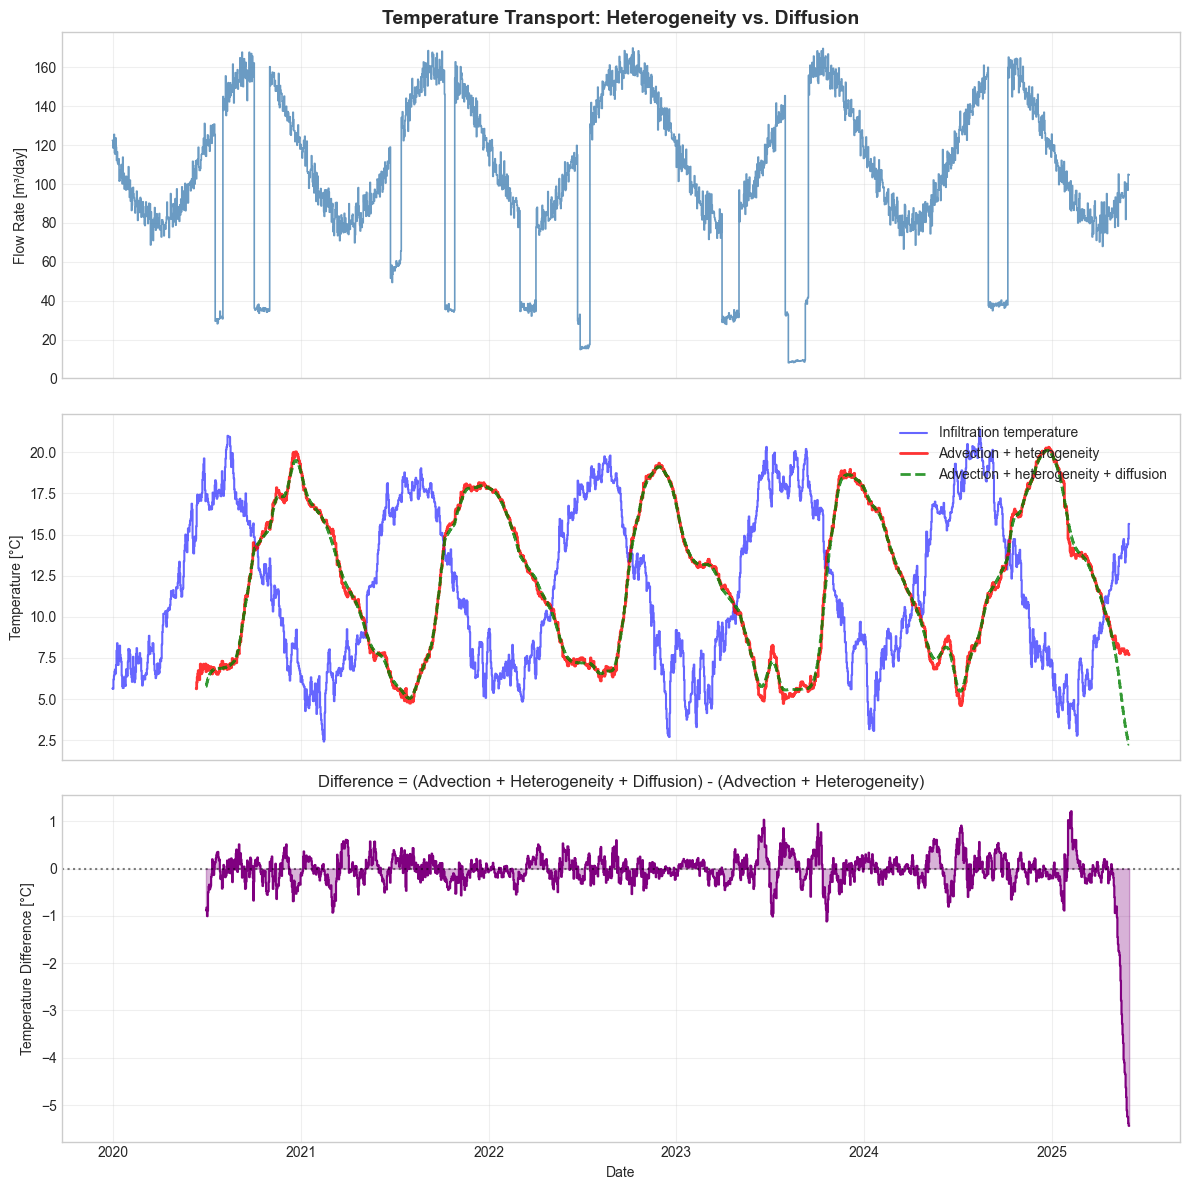


Temperature difference statistics:
Maximum absolute difference: 5.441 °C
Root mean square difference:  0.518 °C
Mean temperature range:       19.0 °C
Relative error (RMSE/range):  2.73%

Temperature plot saved to: 05_Temperature_diffusion_effect.png


In [9]:
# Plot temperature breakthrough with and without diffusion
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Panel 1: Flow rate - convert to step format
xstep_flow, ystep_flow = np.repeat(tedges, 2)[1:-1], np.repeat(df.flow, 2)
ax1.plot(xstep_flow, ystep_flow, color="steelblue", alpha=0.8, linewidth=1.2)
ax1.set_ylabel("Flow Rate [m³/day]")
ax1.set_title("Temperature Transport: Heterogeneity vs. Diffusion", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)

# Panel 2: Temperature comparison - convert all series to step format
xstep_temp_in, ystep_temp_in = np.repeat(tedges, 2)[1:-1], np.repeat(df.temp_infiltration, 2)
xstep_temp_adv, ystep_temp_adv = np.repeat(tedges, 2)[1:-1], np.repeat(temp_advection_only, 2)
xstep_temp_diff, ystep_temp_diff = np.repeat(tedges, 2)[1:-1], np.repeat(temp_advection_diffusion, 2)
ax2.plot(xstep_temp_in, ystep_temp_in, label="Infiltration temperature", color="blue", alpha=0.6, linewidth=1.5)
ax2.plot(xstep_temp_adv, ystep_temp_adv, label="Advection + heterogeneity", color="red", linewidth=2, alpha=0.8)
ax2.plot(
    xstep_temp_diff,
    ystep_temp_diff,
    label="Advection + heterogeneity + diffusion",
    color="green",
    linewidth=2,
    linestyle="--",
    alpha=0.8,
)
ax2.set_ylabel("Temperature [°C]")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

# Panel 3: Difference between models - convert to step format
temp_difference = temp_advection_diffusion - temp_advection_only
xstep_diff_val, ystep_diff_val = np.repeat(tedges, 2)[1:-1], np.repeat(temp_difference, 2)
ax3.plot(xstep_diff_val, ystep_diff_val, color="purple", linewidth=1.5)
ax3.axhline(0, color="black", linestyle=":", alpha=0.5)
ax3.fill_between(xstep_diff_val, 0, ystep_diff_val, alpha=0.3, color="purple")
ax3.set_ylabel("Temperature Difference [°C]")
ax3.set_xlabel("Date")
ax3.set_title("Difference = (Advection + Heterogeneity + Diffusion) - (Advection + Heterogeneity)")
ax3.grid(True, alpha=0.3)

plt.tight_layout()

# Save plot
out_path = Path("05_Temperature_diffusion_effect.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

# Use nanmax/nanmean to handle NaN values in statistics
max_diff = np.nanmax(np.abs(temp_difference))
rmse = np.sqrt(np.nanmean(temp_difference**2))
print("\nTemperature difference statistics:")
print(f"Maximum absolute difference: {max_diff:.3f} °C")
print(f"Root mean square difference:  {rmse:.3f} °C")
print(f"Mean temperature range:       {df.temp_infiltration.max() - df.temp_infiltration.min():.1f} °C")
print(f"Relative error (RMSE/range):  {rmse / (df.temp_infiltration.max() - df.temp_infiltration.min()) * 100:.2f}%")
print(f"\nTemperature plot saved to: {out_path}")

## Key Takeaways

For this example:

- Variance ratio = 0.13 (diffusion contributes 13% of total variance)
- Temperature RMSE difference ≈ 0.05°C (small but measurable)
- **Conclusion**: Advection-only model is acceptable for this case

### Decision Rule

Use the variance ratio to decide whether to include diffusion:

- **Ratio < 0.1**: Diffusion negligible → Advection-only model appropriate
- **Ratio 0.1-0.5**: Diffusion minor → May affect high-precision work
- **Ratio > 0.5**: Diffusion important → Must include diffusion

### When Diffusion Matters More

Diffusion becomes important when:

- Long flow paths (increases residence time)
- High diffusivity materials (coarse sand, thermal transport)
- Low aquifer heterogeneity (small advection variance)
